In [2]:
## 라이브러리 불러오기

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv('./WA_Fn-UseC_-HR-Employee-Attrition.csv')
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# EDA 진행

### 1. 결측치 / 이상치 검토하기

In [5]:
data.isna().sum()

## 결측치는 존재하지 않음

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeCount               0
EmployeeNumber              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StandardHours               0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSince

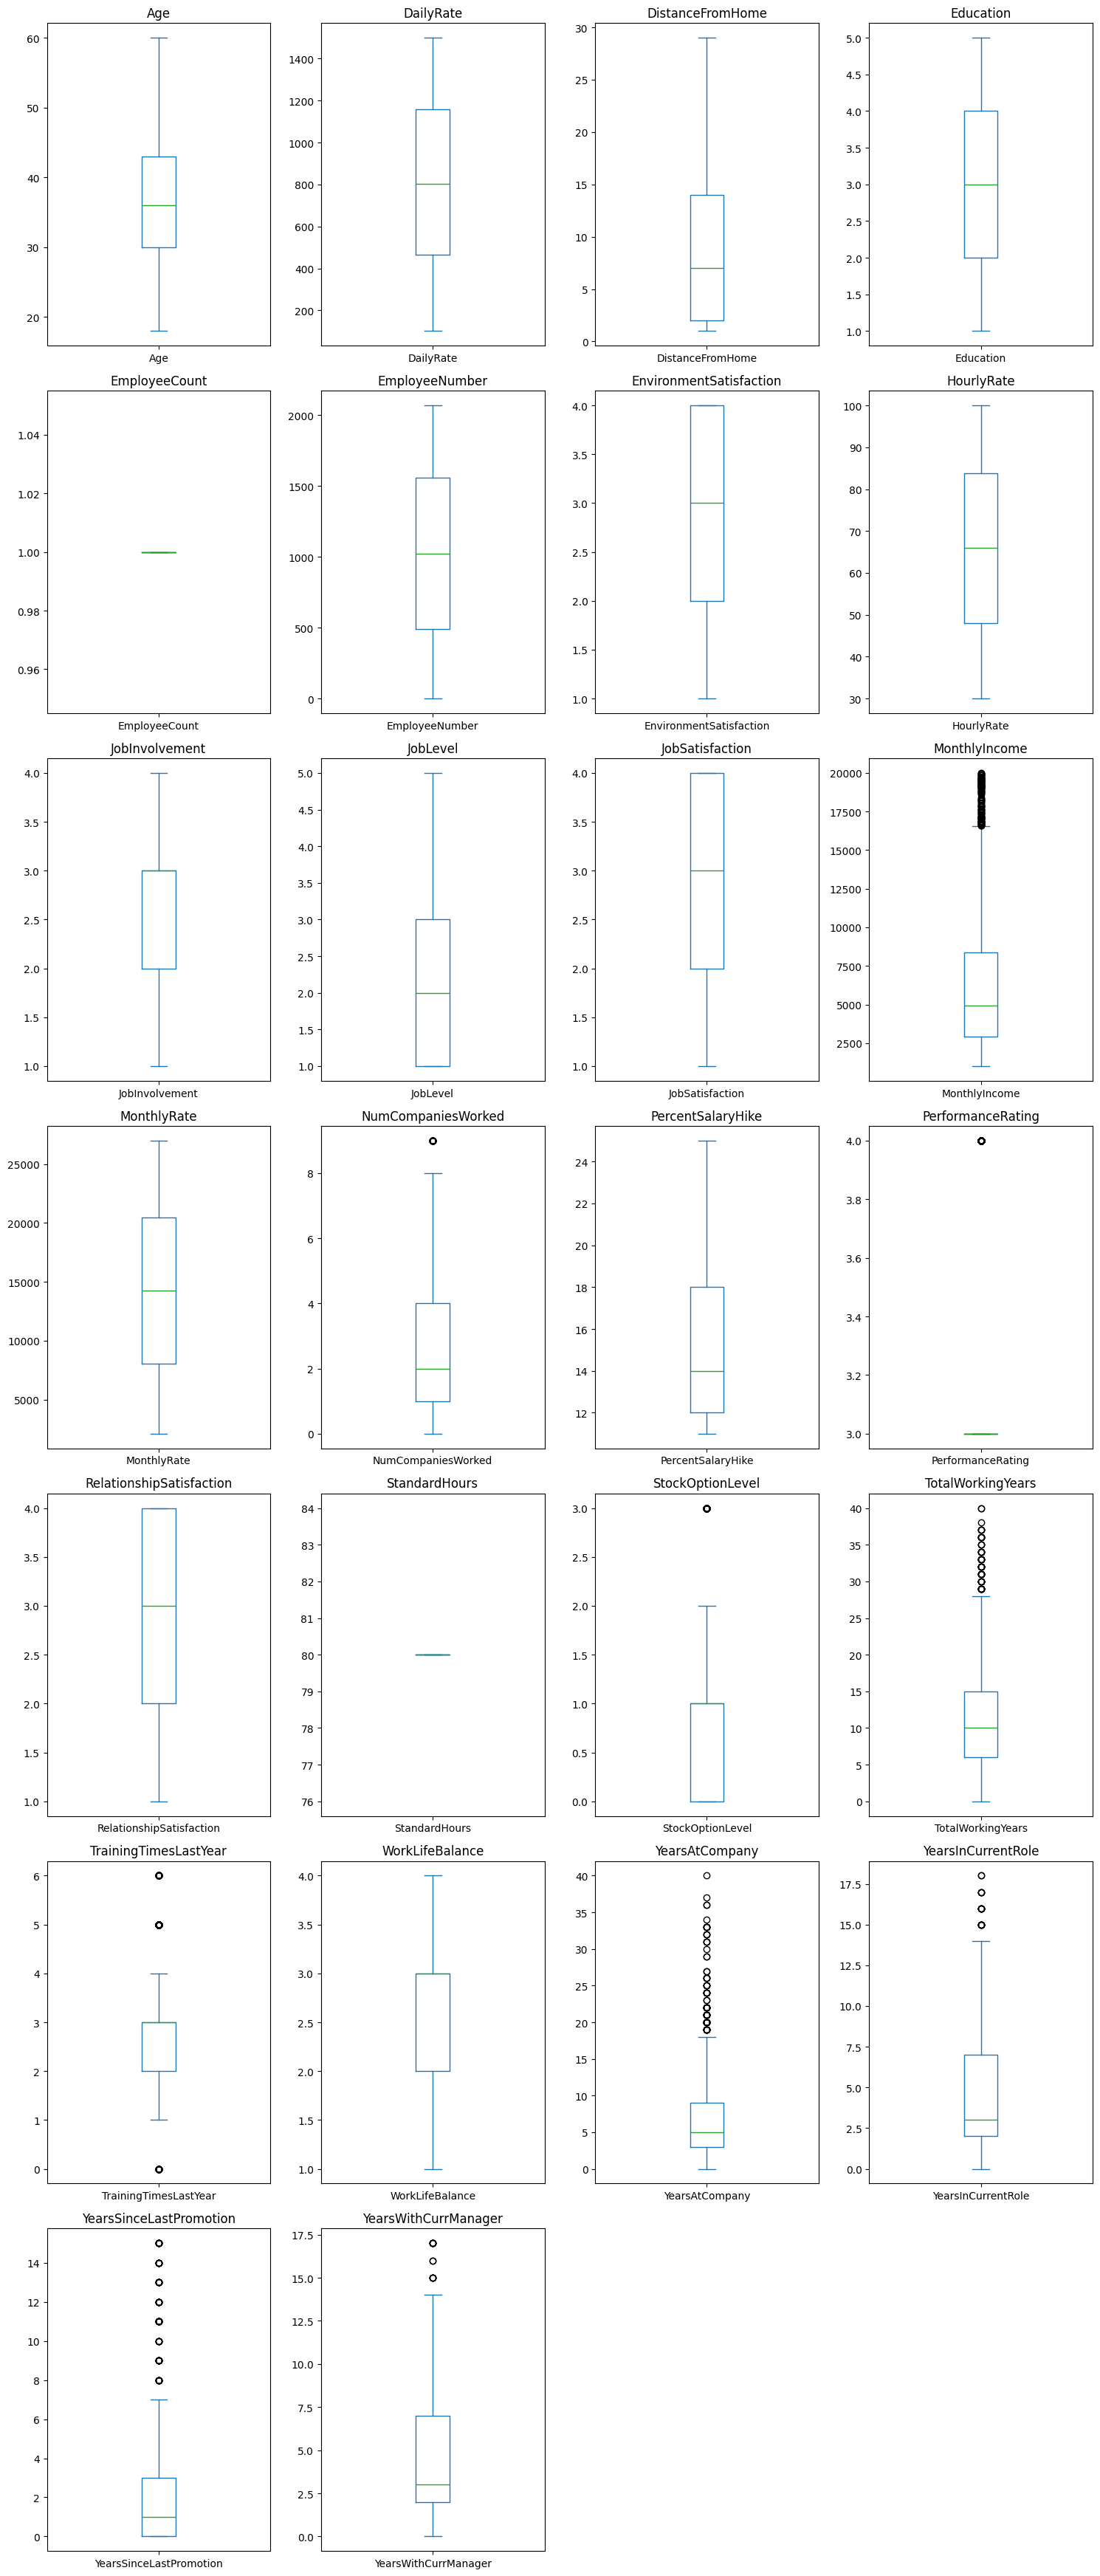

In [17]:
## 연속형 변수만 선택
continuous_columns = data.select_dtypes(include=['float64', 'int64']).columns

## 모두 Boxplot을 그리기 위한 행/열 개수 설정
num_plots = len(continuous_columns)
num_cols = 4
num_rows = math.ceil(num_plots / num_cols)

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(15, 5*num_rows))

## 4개의 열로 모든 연속형 변수 BoxPlot 그리기
for i, column in enumerate(continuous_columns):
    row_idx = i // num_cols
    col_idx = i % num_cols
    data[column].plot(kind='box', ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(column) ## 제목은 변수명으로 설정

##  빈 plot제거
for i in range(num_plots, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

plt.tight_layout()



- 결측치는 0 개
- 이상치는 MonthlyIncome / Performance Rating / TotalWorkingYears / TrainingTimeLastYear / YearsatCompany / YearsSinceLastPromotion / YearsWithCurrManger 의 변수서 발생하였다.

### 2. 유의미한 시각화 수행

2-1 나이별 퇴사 여부

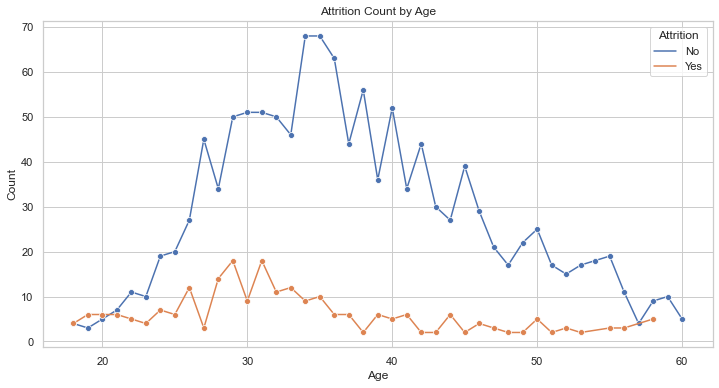

In [7]:
age_resign=data.groupby(['Age','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')

sns.set(style="whitegrid")
plt.figure(figsize=(12, 6)) 
plot = sns.lineplot(x='Age', y='Counts', hue='Attrition', data=age_resign, marker='o')
plot.set(xlabel='Age', ylabel='Count', title='Attrition Count by Age')



약 28-30세에서 높은 퇴직수를 보이고 나이가 들수록 퇴직 수는 감소한다. 

2-2 monthly income에 따른 퇴사 여부

[Text(0.5, 0, 'MonthlyIncome'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Monthly Income ')]

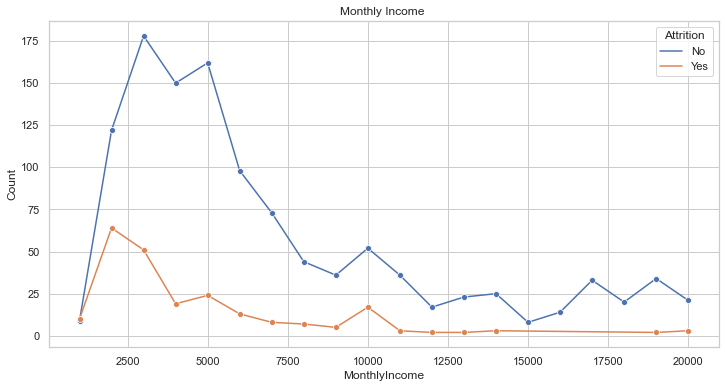

In [33]:
rate_att=data.groupby(['MonthlyIncome','Attrition']).apply(lambda x:x['MonthlyIncome'].count()).reset_index(name='Counts')
rate_att['MonthlyIncome']=round(rate_att['MonthlyIncome'],-3)
rate_att=rate_att.groupby(['MonthlyIncome','Attrition']).apply(lambda x:x['MonthlyIncome'].count()).reset_index(name='Counts')


plt.figure(figsize=(12, 6))  
plot = sns.lineplot(x='MonthlyIncome', y='Counts', hue='Attrition', data=rate_att, marker='o')
plot.set(xlabel='MonthlyIncome', ylabel='Count', title='Monthly Income ')


- 월급이 아주 적을 경우 퇴사율이 높을 분더러
- 월급이 10000을 넘어가는 순간 퇴사를 결정하는 사람들이 많이 있음을 시사
- 많은 월급을 받는 경우 적은 퇴사율을 보임

2-3 만족도별 퇴직비율

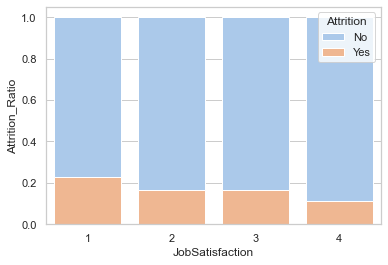

In [28]:
jsats_att=data.groupby(['JobSatisfaction','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')

# JobSatisfaction 그룹에서 'Yes' 비율 계산
jsats_att['Attrition_Ratio'] = jsats_att.groupby('JobSatisfaction')['Counts'].transform(lambda x: x / x.sum())
jsats_att['Attrition_Ratio'] = jsats_att['Attrition_Ratio'].where(jsats_att['Attrition'] == 'Yes', 1)
plot = sns.barplot(x='JobSatisfaction', y='Attrition_Ratio', hue='Attrition', data=jsats_att, dodge=False, palette='pastel')


만족도가 낮을수록 (1 : 'Low', ~ 4 : 'Very High') 높은 퇴사율을 보임 (비율 1.0 기준)

2-4 현재 직급을 유지한 기간 별 퇴사

[Text(0.5, 0, 'YearsInCurrentRole'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'YearsInCurrentRole')]

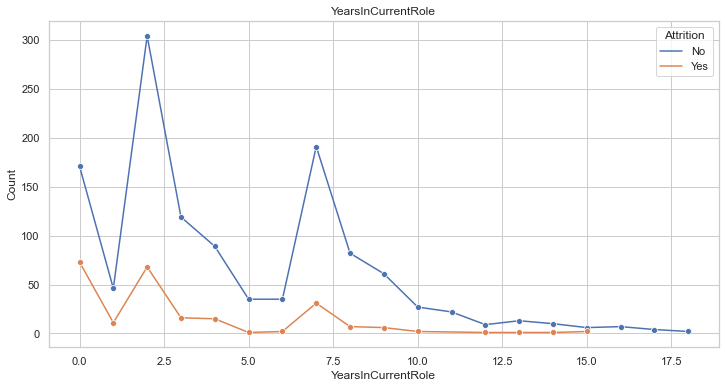

In [32]:
yrscr_att=data.groupby(['YearsInCurrentRole','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')

plt.figure(figsize=(12, 6)) 
plot = sns.lineplot(x='YearsInCurrentRole', y='Counts', hue='Attrition', data=yrscr_att, marker='o')
plot.set(xlabel='YearsInCurrentRole', ylabel='Count', title='YearsInCurrentRole')


약 2~2.5년과 6~7년차에서 많은 퇴사율을 보임 이를 제외하면 거의 퇴사를 하지 않는 것을 볼 수 있음

2-5 연봉인상률과 퇴사율의 관계

[Text(0.5, 0, 'PercentSalaryHike'),
 Text(0, 0.5, 'Count'),
 Text(0.5, 1.0, 'Monthly Income ')]

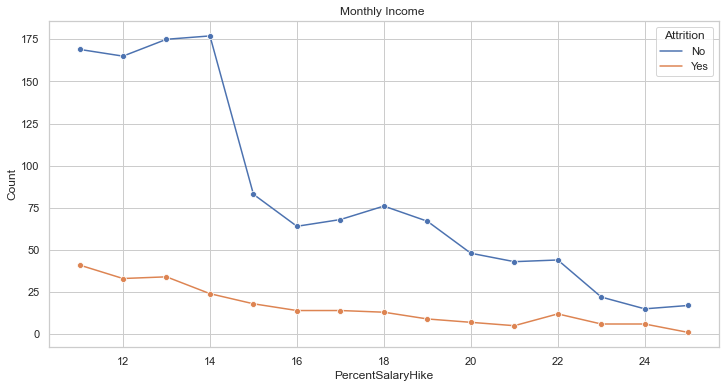

In [35]:
hike_att=data.groupby(['PercentSalaryHike','Attrition']).apply(lambda x:x['DailyRate'].count()).reset_index(name='Counts')

plt.figure(figsize=(12, 6))  
plot = sns.lineplot(x='PercentSalaryHike', y='Counts', hue='Attrition', data=hike_att, marker='o')
plot.set(xlabel='PercentSalaryHike', ylabel='Count', title='Monthly Income ')



연봉 인상률이 높을 수록 퇴사횟수가 낮아지는 것을 알 수 있음

### 3. 수치형 변수간 상관관계 파악하기

Text(0.5, 1.0, 'Correlation Matrix of Numeric Variables')

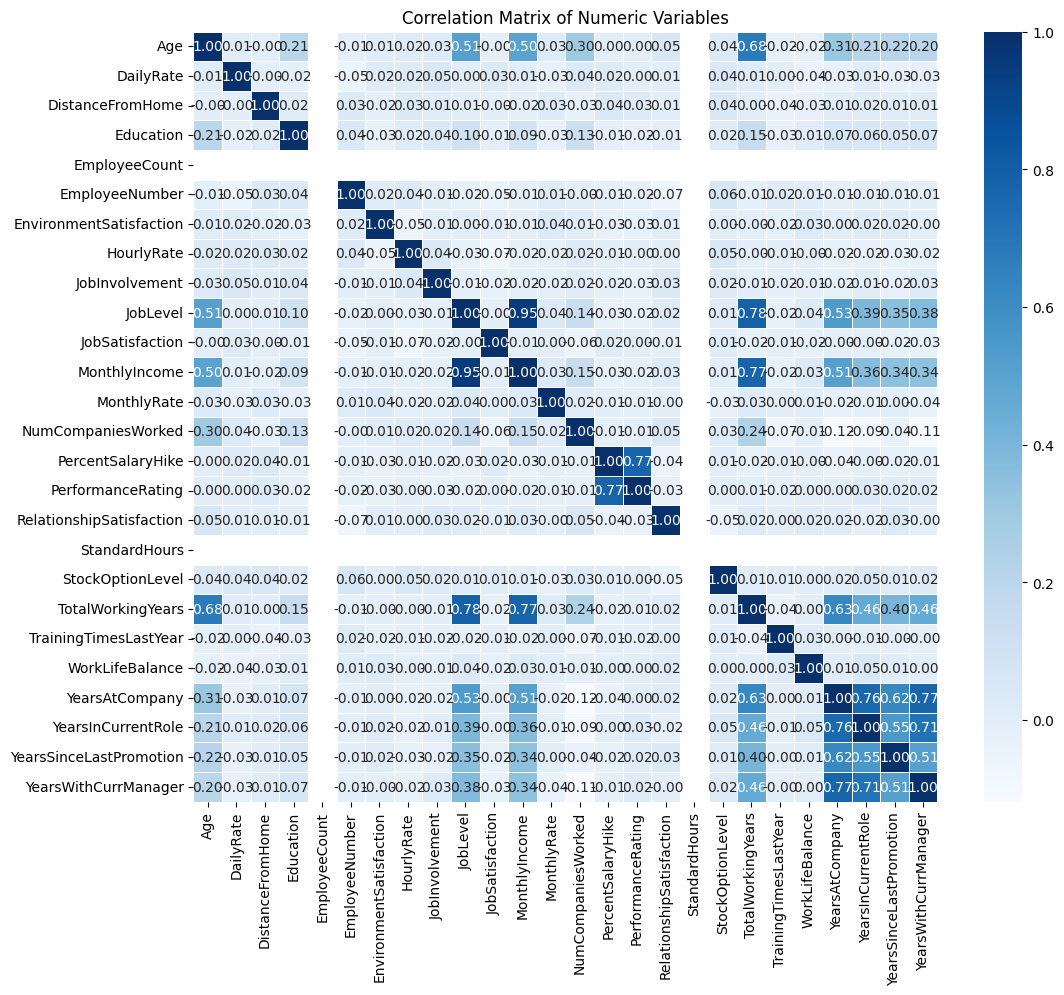

In [21]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns


correlation = data[numeric_columns].corr()

# 히트맵을 그린다
plt.figure(figsize=(12, 10))
sns.heatmap(correlation, cmap='Blues', annot=True, fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Numeric Variables')

나이와 관련하여 회사와 관련한 Years변수 그리고 수입 / 등급 등이 높은 상관관계를 이룬다.

### 4. 파생변수 생성하기

In [ ]:
## 전년도 연봉
data['LastYearSalary'] = (data['MonthlyIncome'] * 12) /  (1 + data['PercentSalaryHike'])

## 현재 등급을 제외한 근무 연수
data['BeforeLevelYearsatCompany'] = data['YearsAtCompany'] - data['YearsInCurrentRole']

## 업무 환경 / 업무에 대한 복합적 만족도
data['SatisfactionofJobEnv'] = data['EnvironmentSatisfaction'] * data['JobSatisfaction']